# Обучение DQN для игры в “Pong-v0”.

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

if COLAB:
  !sudo apt-get install -y xvfb ffmpeg
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q --upgrade tensorflow-probability
  !pip install -q tf-agents

Note: using Google CoLab
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 2s (419 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting p

In [3]:
!pip install ale-py

     |████████████████████████████████| 1.6 MB 4.0 MB/s 


In [4]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

In [5]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Гиперпараметры

In [6]:
num_iterations = 250000 

initial_collect_steps = 200  
collect_steps_per_iteration = 10 
replay_buffer_max_length = 100000

batch_size =   32
learning_rate = 2.5e-3
log_interval =   5000

num_eval_episodes = 5  
eval_interval = 25000  

# Окружающая среда Atari

In [7]:
!pip3 install atari-py==0.2.9

In [8]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2021-10-20 16:52:48--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   257KB/s    in 45s     

2021-10-20 16:53:33 (244 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (P

In [9]:
env_name = 'Pong-v0'
env = suite_gym.load(env_name)

ATARI_FRAME_SKIP = 1

max_episode_frames=108000

env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):
/usr/local/lib/python3.7/dist-packages/ale_py/roms/__init__.py:84: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  __all__ = _resolve_roms()
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


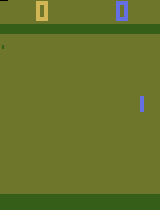

In [10]:
env.reset()
PIL.Image.fromarray(env.render())

In [11]:
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Агент

In [12]:
ATARI_FRAME_SKIP = 4

class AtariCategoricalQNetwork(network.Network):
  """CategoricalQNetwork subclass that divides observations by 255."""

  def __init__(self, input_tensor_spec, action_spec, **kwargs):
    super(AtariCategoricalQNetwork, self).__init__(
        input_tensor_spec, state_spec=())
    input_tensor_spec = tf.TensorSpec(
        dtype=tf.float32, shape=input_tensor_spec.shape)
    self._categorical_q_network = categorical_q_network.CategoricalQNetwork(
        input_tensor_spec, action_spec, **kwargs)

  @property
  def num_atoms(self):
    return self._categorical_q_network.num_atoms

  def call(self, observation, step_type=None, network_state=()):
    state = tf.cast(observation, tf.float32)
    state = state / 255
    return self._categorical_q_network(
        state, step_type=step_type, network_state=network_state)

In [13]:
# Затем мы вводим два гиперпараметра, специфичных для нейронной сети, которую мы собираемся определить.
fc_layer_params = (512,)
conv_layer_params=((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1))

q_net = AtariCategoricalQNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            conv_layer_params=conv_layer_params,
            fc_layer_params=fc_layer_params)

In [14]:
optimizer = tf.compat.v1.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.95,
    momentum=0.0,
    epsilon=0.00001,
    centered=True)

train_step_counter = tf.Variable(0)

observation_spec = tensor_spec.from_spec(train_env.observation_spec())
time_step_spec = ts.time_step_spec(observation_spec)

action_spec = tensor_spec.from_spec(train_env.action_spec())
target_update_period=32000  # ALE frames
update_period=16  # ALE frames
_update_period = update_period / ATARI_FRAME_SKIP


agent = categorical_dqn_agent.CategoricalDqnAgent(
    time_step_spec,
    action_spec,
    categorical_q_network=q_net,
    optimizer=optimizer,
    #epsilon_greedy=epsilon,
    n_step_update=1.0,
    target_update_tau=1.0,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period),
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False)

agent.initialize()

In [15]:
q_net.input_tensor_spec

BoundedTensorSpec(shape=(84, 84, 4), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))

In [16]:
train_env.observation_spec()

BoundedTensorSpec(shape=(84, 84, 4), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))

In [17]:
train_py_env.observation_spec()

BoundedArraySpec(shape=(84, 84, 4), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [18]:
train_py_env

# Метрики и оценка

Данный Метод, используемый ниже, отслеживает среднее вознаграждение, полученное за несколько эпизодов.

In [19]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

## Replay Buffer

In [20]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# Датасет генерирует траектории с формой [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

Instructions for updating:
Use `tf.data.Dataset.scan(...) instead
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


## Random Collection

Следующий код выполняет предварительно определенное количество шагов для генерации исходных обучающих данных.

In [21]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Добавляет траекторию в буфер воспроизведения
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, \
             steps=initial_collect_steps)

## Обучение агента

In [22]:
iterator = iter(dataset)

agent.train = common.function(agent.train)

# Сбросить шаг обучения.
agent.train_step_counter.assign(0)

# Оценивает один раз политику агента перед обучением.
avg_return = compute_avg_return(eval_env, agent.policy, \
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Собериет несколько шагов с помощью collect_policy и сохраните в буфер воспроизведения.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Выполняет выборку пакета данных из буфера и обновляет сеть агента.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, \
                                    num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 5000: loss = 3.8968467712402344
step = 10000: loss = 3.8814122676849365
step = 15000: loss = 3.822768211364746
step = 20000: loss = 3.700294017791748
step = 25000: loss = 3.7938392162323
step = 25000: Average Return = -21.0
step = 30000: loss = 3.802783966064453
step = 35000: loss = 3.684950828552246
step = 40000: loss = 3.5464000701904297
step = 45000: loss = 3.4763357639312744
step = 50000: loss = 3.5134165287017822
step = 50000: Average Return = -20.399999618530273
step = 55000: loss = 3.51108455657959
step = 60000: loss = 3.4928622245788574
step = 65000: loss = 3.502441644668579
step = 70000: loss = 3.57584285736084
step = 75000: loss = 3.152644395828247
step = 75000: Average Return = -20.600000381469727
step = 80000: loss = 3.388947010040283
step = 85000: loss = 3.462456464767456
step = 90000: loss = 3.317254066467285


KeyboardInterrupt: ignored

## Визуализация

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=10)

## Видео

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
# Сначала мы посмотрим, как обученный агент играет в игру.
create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:
#create_policy_eval_video(random_policy, "random-agent")